In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nbimporter

import central_system as cs
import analyze_control as ac
import read_load as rl

import exp_study_case
import exp_external_conditions
import exp_system_spec
import exp_house_spec
import exp_general_property
import exp_occupant_usage
import exp_circulating_air_flow
import exp_load
import exp_treated_and_untreated_heat
from exp_theoretical_efficiency import get_e_th_h_test, get_e_th_c_test, get_e_th_h, get_e_th_c

# 日本語フォント
import pylab
from matplotlib.font_manager import FontProperties
fp = FontProperties(fname='C:\WINDOWS\Fonts\msgothic.ttc', size = 12)

Importing Jupyter notebook from exp_study_case.ipynb
Importing Jupyter notebook from exp_external_conditions.ipynb
Importing Jupyter notebook from exp_system_spec.ipynb
Importing Jupyter notebook from exp_house_spec.ipynb
Importing Jupyter notebook from exp_general_property.ipynb
Importing Jupyter notebook from exp_occupant_usage.ipynb
Importing Jupyter notebook from exp_circulating_air_flow.ipynb
Importing Jupyter notebook from exp_load.ipynb
Importing Jupyter notebook from exp_treated_and_untreated_heat.ipynb
Importing Jupyter notebook from exp_theoretical_efficiency.ipynb


# 0. 検討ケース

試算するケースを取得します。

In [2]:
case = exp_study_case.get_case()
case

{'region': 6,
 'house': {'a_mr': 29.81,
  'a_or': 51.34,
  'a_a': 120.08,
  'r_env': 2.9555555555555557,
  'insulation': 'h11',
  'solar_gain': 'middle'},
 'system': {'default_heat_source_spec': True,
  'v_hs_rtd_h': 1800.0,
  'v_hs_rtd_c': 1800.0,
  'is_duct_insulated': True,
  'vav_system': False,
  'cap_rtd_h': None,
  'cap_rtd_c': None}}

1日グラフを描画する日を取得します。

In [3]:
hday, cday = exp_study_case.get_display_day()

## 1. 外部モジュールの読み込み

### 熱源機の仕様

外部モジュール exp_system_spec を参照のこと。

$q_{rtd,H}$：定格暖房能力, W  
$q_{rtd,C}$：定格冷房能力, W  
$V_{hs,rtd,H}$：熱源機の暖房時の定格風量, m<sup>3</sup>/h  
$V_{hs,rtd,C}$：熱源機の冷房時の定格風量, m<sup>3</sup>/h  

In [4]:
q_rtd_h, q_rtd_c, v_hs_rtd_h, v_hs_rtd_c, is_duct_insulated, vav_system, p_rtd_h, p_rtd_c = \
    exp_system_spec.get_system_spec(case['region'], case['house']['a_a'], case['system'])

q_rtd_h, q_rtd_c, v_hs_rtd_h, v_hs_rtd_c, is_duct_insulated, vav_system, p_rtd_h, p_rtd_c

(7733.9925600000015,
 7664.646360000001,
 1654.226845584,
 1654.226845584,
 True,
 False,
 2056.9129148936177,
 2417.8695141955836)

### 住宅の仕様

外部モジュール exp_house_spec を参照のこと。  

$r_{env}$：床面積の合計に対する外皮の部位の面積の合計の比  
$A_A$：床面積の合計, m<sup>2</sup>  
$A_{MR}$：主たる居室の床面積, m<sup>2</sup>  
$A_{OR}$：その他の居室の床面積, m<sup>2</sup>  
$A_{NR}$：非居室の床面積, m<sup>2</sup>  
$A_{HCZ,R,i}$：標準住戸における暖冷房区画 $i$ の床面積, m<sup>2</sup>  
$A_{HCZ,i}$：暖冷房区画 $i$ の床面積, m<sup>2</sup>  
$A_{prt,i}$：暖冷房区画 $i$ から見た非暖冷房空間の間仕切りの面積, m<sup>2</sup>  
$U_{prt}$：間仕切りの熱貫流率, W/m<sup>2</sup>K  
$Q$：熱損失係数, W/m<sup>2</sup>K  
$\mu_H$：暖房期の日射取得係数, ((W/m<sup>2</sup>)/(W/m<sup>2</sup>))  
$\mu_C$：冷房期の日射取得係数, ((W/m<sup>2</sup>)/(W/m<sup>2</sup>))  
$V_{vent,i}$：暖冷房区画 $i$ の機械換気量, m<sup>3</sup>/h  

In [5]:
r_env, a_a, a_mr, a_or, a_nr, a_hcz, a_prt, u_prt, q, mu_h, mu_c, v_vent = \
    exp_house_spec.get_house_spec(case['region'], case['house'])
r_env, a_a, a_mr, a_or, a_nr, a_hcz, a_prt, u_prt, q, mu_h, mu_c, v_vent

(2.9555555555555557,
 120.08,
 29.81,
 51.34,
 38.92999999999999,
 array([29.81, 16.56, 13.25, 10.76, 10.77,  3.31,  1.66,  3.31, 13.25,
         4.97, 10.77,  1.66]),
 array([37.99636619, 27.7187943 , 22.17838312, 18.01052093, 18.02725933]),
 2.1739130434782608,
 2.7,
 0.101,
 0.062,
 array([60., 20., 40., 20., 20.]))

### 物性値

外部モジュール exp_general_property を参照のこと。

$\rho$：空気の密度, kg/m<sup>3</sup>  
$c$：空気の比熱, J/kgK  
$L_{wtr}$：水の蒸発潜熱, kJ/kg  
「平日」「休日」の別

In [6]:
rho, c, l_wtr, calender = exp_general_property.get_general_property()
rho, c, l_wtr, calender

(1.2,
 1006.0,
 2434.5296000000003,
 array(['休日', '休日', '休日', ..., '休日', '休日', '休日'], dtype=object))

### 気候条件

外部モジュール exp_external_conditions を参照のこと。

$\theta_{ex,d,t}$：日付$d$の時刻$t$における外気温度, ℃  
$x_{ex,d,t}$：日付$d$の時刻$t$における絶対湿度, kg/kg(DA)  
$h_{ex_d,t}$：日付$d$の時刻$t$における相対湿度, %  
$J_{d,t}$：日付$d$の時刻$t$における水平面全天日射量, W/m<sup>2</sup>  
$\theta_{SAT,d,t}$：日付$d$の時刻$t$における水平面における等価外気温度, ℃  

In [7]:
theta_ex, x_ex, h_ex, j, theta_sat = exp_external_conditions.get_external_conditions(case['region'])
theta_ex, x_ex, h_ex, j, theta_sat

(array([2.6, 2.9, 2.8, ..., 3.1, 2.7, 2.3]),
 array([0.0033, 0.0032, 0.0032, ..., 0.0032, 0.0032, 0.0032]),
 array([72.52135498, 68.85197153, 69.34240102, ..., 67.88267058,
        69.83672797, 71.8536949 ]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([2.6, 2.9, 2.8, ..., 3.1, 2.7, 2.3]))

### 居住者の使い方

外部モジュール exp_occupant_usage を参照のこと。

暖冷房期間  
$n_{p,d,t}$：日付$d$の時刻$t$における在室人数  
$q_{gen,d,t}$：日付$d$の時刻$t$における内部発熱, W  
$w_{gen,d,t}$：日付$d$の時刻$t$における内部発湿, g/h  
$V_{local,d,t}$：日付$d$時刻$t$における局所換気量, m<sup>3</sup>/h  
$V_{local,MR,d,t}$：日付$d$時刻$t$における主たる居室の局所換気量, m<sup>3</sup>/h  
$V_{local,OR,d,t}$：日付$d$時刻$t$におけるその他の居室の局所換気量, m<sup>3</sup>/h  
$V_{local,NR,d,t}$：日付$d$時刻$t$における非居室の局所換気量, m<sup>3</sup>/h  
$\theta_{set,h}$：暖房時の設定温度, ℃  
$\theta_{set,c}$：冷房時の設定温度, ℃  
$X_{set,c}$：冷房時の設定絶対湿度, kg/kgDA  

In [8]:
hc_period, n_p, q_gen, w_gen, v_local, v_local_mr, v_local_or, v_local_nr, theta_set_h, theta_set_c, x_set_c \
    = exp_occupant_usage.get_occupant_usage(case['region'], a_mr, a_or, a_nr, calender)
hc_period, n_p, q_gen, w_gen, v_local, v_local_mr, v_local_or, v_local_nr, theta_set_h, theta_set_c, x_set_c

(array(['h', 'h', 'h', ..., 'h', 'h', 'h'], dtype='<U1'),
 array([4., 4., 4., ..., 4., 3., 3.]),
 array([126.4, 126.4, 126.4, ..., 763. , 815. , 242.7]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([  0. ,   0. ,   0. , ...,  25. ,  27. , 100.8]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([  0. ,   0. ,   0. , ...,  25. ,  27. , 100.8]),
 20.0,
 27.0,
 0.013425743)

### 循環風量

外部モジュール exp_circulating_air_flow を参照のこと。

$V'_{supply,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房区画 $i$ へのVAV調整前の吹き出し風量, m<sup>3</sup>/h  

In [9]:
v_d_supply = exp_circulating_air_flow.get_circulating_air_flow(
    a_a, a_hcz, q, mu_h, mu_c, v_vent, theta_ex, x_ex, j, hc_period, n_p, q_gen, w_gen, v_local,
    theta_set_h, theta_set_c, x_set_c,
    q_rtd_h, q_rtd_c, v_hs_rtd_h, v_hs_rtd_c)
v_d_supply

array([[431.73098011, 424.75936241, 427.08323498, ..., 384.98610203,
        397.25927854, 478.51698686],
       [239.83445255, 235.96159146, 237.25254516, ..., 213.86681817,
        220.6847921 , 265.82493467],
       [191.89652756, 188.79777095, 189.83068982, ..., 171.11928386,
        176.57448643, 212.69205219],
       [155.83446313, 153.3180389 , 154.15684698, ..., 138.96177316,
        143.39180936, 172.72199861],
       [155.9792907 , 153.46052778, 154.30011542, ..., 139.09091979,
        143.52507312, 172.88252092]])

### 暖冷房負荷

外部モジュール exp_load を参照のこと。

$\theta_{ac,d,t}$：日付 $d$ の時刻 $t$ における暖冷房室の温度, ℃  
$X_{ac,d,t}$：日付 $d$ の時刻 $t$ における暖冷房室の絶対湿度, kg/kgDA  
$\theta'_{nac,d,t}$：日付 $d$ の時刻 $t$ における負荷バランス時（※）の非暖冷房空間の温度, ℃  
$X'_{nac,d,t}$：日付 $d$ の時刻 $t$ における負荷バランス時（※）の非暖冷房空間の絶対湿度, kg/kgDA  
$L'_{H,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱損失を含む暖房負荷, MJ/h  
$L'_{CS,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱取得を含む顕熱冷房負荷, MJ/h  
$L'_{CL,d,t,i}$：日付 $d$ の時刻 $t$ における室 $i$ の1時間当たりの負荷バランス時（※）の間仕切り熱取得を含む潜熱冷房負荷, MJ/h  

In [10]:
theta_ac, x_ac, theta_d_nac, x_d_nac, l_d_h, l_d_cs, l_d_cl = exp_load.get_load(
    case['region'], case['house'], hc_period, theta_ex, x_ex, theta_set_h, theta_set_c, x_set_c,
    q, a_nr, v_local_nr, v_d_supply, u_prt, a_prt)
theta_ac, x_ac, theta_d_nac, x_d_nac, l_d_h, l_d_cs, l_d_cl

(array([20., 20., 20., ..., 20., 20., 20.]),
 array([0.0033, 0.0032, 0.0032, ..., 0.0032, 0.0032, 0.0032]),
 array([18.14819847, 18.13408239, 18.13369986, ..., 18.19891006,
        17.50034825, 18.33028546]),
 array([0.0033, 0.0032, 0.0032, ..., 0.0032, 0.0032, 0.0032]),
 array([[6.25375701, 6.21285461, 6.23357836, ..., 4.87304727, 6.23606361,
         6.2312911 ],
        [2.73031074, 2.72120294, 2.72807592, ..., 2.54324989, 2.80356869,
         2.70500066],
        [1.80262711, 1.78426724, 1.78618363, ..., 2.1278451 , 1.90620444,
         1.78436228],
        [1.67820495, 1.66276464, 1.66718856, ..., 1.14868705, 1.70493067,
         1.65547944],
        [2.08309753, 2.06547907, 2.06983304, ..., 1.56256299, 2.09474812,
         2.05808817]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[-0., -0., -0., ..., -0., -0., -0.],
    

### 処理・未処理熱量

外部モジュール exp_treated_and_untreated_heat を参照のこと。

$\theta_{hs,in,d,t}$：日付 $d$ の時刻 $t$ における熱源機入り口温度, ℃  
$X_{hs,in,d,t}$：日付 $d$ の時刻 $t$ における熱源機入り口絶対湿度, kg/kgDA  
$\theta_{hs,out,H,d,t}$：日付 $d$ の時刻 $t$ における暖房時の熱源機の出口空気温度, ℃  
$\theta_{hs,out,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の熱源機の出口空気温度, ℃  
$X_{hs,out,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の熱源機の出口空気絶対湿度, kg/kgDA  
$V_{supply,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房区画 $i$ への吹き出し風量, m<sup>3</sup>/h  
運転状態：'h'=暖房運転中, 'c'=冷房運転中, 'n'=運転停止中

In [11]:
theta_hs_in, x_hs_in, theta_hs_out_h, theta_hs_out_c, x_hs_out_c, v_supply, operation = exp_treated_and_untreated_heat.get_heat(
    case['region'], a_a, a_hcz, u_prt, a_prt, q, a_nr, q_rtd_h, q_rtd_c,
    theta_sat, theta_ac, x_ac, is_duct_insulated, theta_d_nac, x_d_nac, vav_system,
    hc_period, l_d_h, l_d_cs, l_d_cl, v_d_supply, v_vent, v_local_nr)

In [12]:
theta_hs_in, x_hs_in, theta_hs_out_h, theta_hs_out_c, x_hs_out_c, v_supply, operation

(array([18.45523478, 18.44089875, 18.44152019, ..., 18.3499633 ,
        17.78408525, 18.61440392]),
 array([0.0033, 0.0032, 0.0032, ..., 0.0032, 0.0032, 0.0032]),
 array([31.11301145, 31.23123799, 31.1947806 , ..., 30.58410861,
        32.32572968, 29.86998459]),
 array([20., 20., 20., ..., 20., 20., 20.]),
 array([0.0033, 0.0032, 0.0032, ..., 0.0032, 0.0032, 0.0032]),
 array([[431.73098011, 424.75936241, 427.08323498, ..., 384.98610203,
         397.25927854, 478.51698686],
        [239.83445255, 235.96159146, 237.25254516, ..., 213.86681817,
         220.6847921 , 265.82493467],
        [191.89652756, 188.79777095, 189.83068982, ..., 171.11928386,
         176.57448643, 212.69205219],
        [155.83446313, 153.3180389 , 154.15684698, ..., 138.96177316,
         143.39180936, 172.72199861],
        [155.9792907 , 153.46052778, 154.30011542, ..., 139.09091979,
         143.52507312, 172.88252092]]),
 array(['h', 'h', 'h', ..., 'h', 'h', 'h'], dtype='<U1'))

## 2. 処理熱量

「暖房運転中」

$$ Q_{hs,H,d,t} = \left( \theta_{hs,out,H,d,t} - \theta_{hs,in,d,t} \right) c \rho \sum_{i=1}^5{V_{supply,d,t,i}} \times 10^{-6} $$

「暖房運転中」以外

$$ Q_{hs,H,d,t} = 0 $$

「冷房運転中」

$$ Q_{hs,CS,d,t} = \left( \theta_{hs,in,d,t} - \theta_{hs,out,C,d,t} \right) c \rho \sum_{i=1}^5{V_{supply,d,t,i}} \times 10^{-6} $$

$$ Q_{hs,CL,d,t} = \left( X_{hs,in,d,t} - X_{hs,out,C,d,t} \right) L_{wtr} \rho \sum_{i=1}^5{V_{supply,d,t,i}} \times 10^{-3} $$ 

$$ Q_{hs,C,d,t} = Q_{hs,CS,d,t} + Q_{hs,CL,d,t} $$

「冷房運転中」以外

$$ Q_{hs,CS,d,t} = 0 $$

$$ Q_{hs,CL,d,t} = 0 $$

$$ Q_{hs,C,d,t} = 0 $$

$Q_{hs,H,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの熱源機の暖房出力, MJ/h  
$Q_{hs,CS,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの熱源機の冷房顕熱出力, MJ/h  
$Q_{hs,CL,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの熱源機の冷房潜熱出力, MJ/h  
$Q_{hs,C,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの熱源機の冷房全熱出力, MJ/h  
$\theta_{hs,out,H,d,t}$：日付 $d$ の時刻 $t$ における暖房時の熱源機の出口空気温度, ℃  
$\theta_{hs,out,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の熱源機の出口空気温度, ℃  
$X_{hs,out,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の熱源機の出口絶対湿度, ℃  
$\theta_{hs,in,d,t}$：日付 $d$ の時刻 $t$ における熱源機の入口空気温度, ℃  
$X_{hs,in,d,t}$：日付 $d$ の時刻 $t$ における熱源機の入口絶対湿度, ℃  
$c$：空気の比熱, J/kgK  
$\rho$：空気の密度, kg/m<sup>3</sup>  
$L_{wtr}$：水の蒸発潜熱, kJ/kg  
$V_{supply,d,t,i}$：日付 $d$ の時刻 $t$ における暖冷房室 $i$ への吹き出し風量, m<sup>3</sup>/h  

In [13]:
q_hs_h = cs.get_heat_source_heating_output(theta_hs_out_h, theta_hs_in, v_supply, operation)
q_hs_c, q_hs_cs, q_hs_cl = cs.get_heat_source_cooling_output(theta_hs_in, x_hs_in, theta_hs_out_c, x_hs_out_c, v_supply, operation)

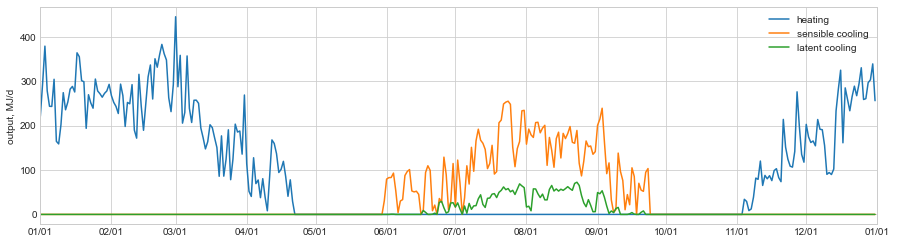

In [14]:
ac.draw_graph(y_title='output, MJ/d', ys=[
    (q_hs_h, 'heating'),
    (q_hs_cs, 'sensible cooling'),
    (q_hs_cl, 'latent cooling')
], op='itg')

## 2. 試験時の圧縮機の圧縮効率

$$ \eta_{rtd,H} = \frac{e_{rtd,H}}{e_{th,rtd,H}} $$

$$ e_{rtd,H} = \frac{q_{hs,rtd,H}}{P_{hs,rtd,H} - P_{fan,rtd,H}} $$

$\eta_{rtd,H}$：定格暖房能力運転時における圧縮機の圧縮効率   
$e_{rtd,H}$：定格暖房能力運転時における暖房効率  
$e_{th,rtd,H}$：定格暖房能力運転時における冷凍サイクルの理論暖房効率  
$q_{hs,rtd,H}$：空調機の定格暖房能力, W  
$P_{hs,rtd,H}$：空調機の定格暖房消費電力, W   
$P_{fan,rtd,H}$：定格暖房能力運転時における送風機の消費電力, W   

ここで、定格暖房能力運転時における冷凍サイクルの理論暖房効率$e_{th,H,rtd}$は、外気温度 $ \theta_{ex} $ は7℃、顕熱暖房能力 $ q_{hs,H} $ は定格暖房能力能力 $ q_{hs,H,rtd} $、熱源機の風量 $ V_{hs} $ は定格暖房能力運転時における熱源機の風量 $ V_{fan,H,rtd} $、熱源機入口温度 $ \theta_{hs,in,H} $は20℃に等しいとして、冷凍サイクルの計算（モジュール exp_theoretical_efficiency の「暖房試験時」の計算を参照）により求まるものとする。  
また、$\eta_{rtd,H}$は、0.0未満の場合は0.0、1.0より大の場合は1.0とする。

In [15]:
e_th_rtd = get_e_th_h_test(theta_hs_in_h=20.0, q_hs_h=q_rtd_h, v_hs=v_hs_rtd_h, theta_ex=7.0)
e_th_rtd

6.956211461915662

In [32]:
def get_eta_rtd_h(q_hs_rtd_h, p_hs_rtd_h, p_fan_rtd_h, e_th_rtd):
    e_rtd_h = q_hs_rtd_h / (p_hs_rtd_h - p_fan_rtd_h)
    eta_rtd_h = e_rtd_h / e_th_rtd
    return np.clip(eta_rtd_h, 0.0, 1.0)

In [33]:
get_eta_rtd_h(q_hs_rtd_h = q_rtd_h, p_hs_rtd_h=p_rtd_h, p_fan_rtd_h=300, e_th_rtd=e_th_rtd)

0.6328207906372784

### 1) 暖房

### 2) 冷房

$$ \theta_{hs,out,H} = \theta_{hs,in,H} + \frac{ q_{hs,H} }{ c \rho V_{hs,H} } \times 3600 $$

$\theta_{hs,out,H}$：定格暖房能力運転時の吐き出し温度, ℃  
$\theta_{hs,in,H}$：定格暖房能力運転時の吸い込み温度, ℃  
$q_{hs,H}$：定格暖房能力, W  
$V_{hs,H}$：定格暖房能力運転時の風量, m<sup>3</sup>/h  
$\rho$：空気の密度, kg/m<sup>3</sup> (=1.2)    
$c$：空気の比熱, J/kgK (=1006.0)

$$ \theta_{hs,out,C} = \theta_{hs,in,C} - \frac{ q_{hs,CS} }{ c \rho V_{hs,C} } \times 3600 $$

$\theta_{hs,out,C}$：冷房運転時の吐き出し温度, ℃  
$\theta_{hs,in,C}$：冷房運転時の吸い込み温度, ℃  
$q_{hs,CS}$：冷房顕熱能力, W  
$V_{hs,C}$：冷房運転時の風量, m<sup>3</sup>/h  
$\rho$：空気の密度, kg/m<sup>3</sup> (=1.2)    
$c$：空気の比熱, J/kgK (=1006.0)

日付 $d$ の時刻 $t$ における冷凍サイクルの理論暖房効率 $e_{th,H,d,t}$：

$$ \theta_{ex} = \theta_{ex,d,t} $$

$$ q_{cp} = Q_{hs,H,d,t} \div \left( 3600 \times 10^{-6} \right) $$

$$ V_{fan} = V_{fan,d,t} $$


中間暖房能力運転時における冷凍サイクルの理論暖房効率$e_{th,H,mid}$：

$$ \theta_{ex} = 7 $$

$$ q_{cp} = q_{ac,H,mid} $$

$$ V_{fan} = V_{fan,H,mid} $$

最小暖房能力運転時における冷凍サイクルの理論暖房効率$e_{th,H,min}$：

$$ \theta_{ex} = 7 $$

$$ q_{cp} = q_{ac,H,min}   $$

$$ V_{fan} = V_{fan,H,min}  $$

$V_{fan}$：送風機の風量, m<sup>3</sup>/h  
$V_{fan,H,mid}$：中間暖房能力運転時における送風機の風量, m<sup>3</sup>/h  
$V_{fan,H,min}$：最小暖房能力運転時における送風機の風量, m<sup>3</sup>/h  
$V_{fan,H,rtd}$：定格暖房能力運転時における送風機の風量, m<sup>3</sup>/h  
$Q_{hs,H,d,t}$：日付$d$の時刻$t$における1時間当たりの熱源機の暖房出力, MJ/h  
$q_{ac,H,mid}$：空調機の中間暖房能力, W  
$q_{ac,H,min}$：空調機の最小暖房能力, W  
$q_{ac,H,rtd}$：空調機の定格暖房能力, W  
$q_{cp}$：冷凍サイクルの能力, W  
$\theta_{ex}$：外気温度, ℃  
$\theta_{ex,d,t}$：日付 $d$ の時刻 $t$ における外気温度, ℃  

## 圧縮効率

JIS性能試験により得られる値を用いる場合

$$ \eta_{H,mid} = \frac{e_{H,mid}}{e_{th,H,mid}} $$

$$ e_{H,mid} = \frac{q_{hs,H,mid}}{P_{hs,H,mid} - P_{fan,H,mid}} $$

JIS性能試験により得られる値を用いない場合

$$ \eta_{H,mid} = \eta_{H,rtd} \times 0.95 $$

$\eta_{H,mid}$：中間暖房能力運転時における圧縮機の圧縮効率  
$e_{H,mid}$：中間暖房能力運転時における暖房効率  
$e_{th,H,mid}$：中間暖房能力運転時における冷凍サイクルの理論暖房効率  
$q_{hs,H,mid}$：空調機の中間暖房能力, W   
$P_{hs,H,mid}$：空調機の中間暖房消費電力, W   
$P_{fan,H,mid}$：中間暖房能力運転時における送風機の消費電力, W   
$\eta_{H,rtd}$：定格暖房能力運転時における圧縮機の圧縮効率   

JIS性能試験により得られる値を用いる場合

$$ \eta_{H,min} = \frac{e_{H,min}}{e_{th,H,min}} $$

$$ e_{H,min} = \frac{q_{hs,H,min}}{P_{hs,H,min} - P_{fan,H,min}} $$

JIS性能試験により得られる値を用いない場合

$$ \eta_{H,min} = \eta_{H,rtd} \times 0.65 $$

$\eta_{H,min}$：最小暖房能力運転時における圧縮機の圧縮効率(-)  
$e_{H,min}$：最小暖房能力運転時における暖房効率(-)  
$e_{th,H,min}$：最小暖房能力運転時における冷凍サイクルの理論暖房効率(-)  
$q_{hs,H,min}$：空調機の最小暖房能力(W)   
$P_{hs,H,min}$：空調機の最小暖房消費電力(W)   
$P_{fan,H,min}$：最小暖房能力運転時における送風機の消費電力(W)   
$\eta_{H,rtd}$：定格暖房能力運転時における圧縮機の圧縮効率(-)   

In [18]:
def eta_H_rtd(e_H_rtd, e_th_H_rtd):
    '''定格能力運転時における圧縮機の圧縮効率を計算する'''
    # e_H_rtd：定格能力運転時におけ暖房効率(-)
    # e_th_H_rtd：定格能力運転時における冷凍サイクルの理論暖房効率(-)
    
    return e_H_rtd / e_th_H_rtd

In [19]:
# 引数がおかしい
def eta_H_mid(JIS_test_mid, eta_H_rtd, q_ac_H_mid, P_ac_H_mid, P_fan_H_mid, e_th_H_mid):
    '''中間能力運転時における圧縮機の圧縮効率を計算する'''
    # JIS_test_mid:JIS試験値を用いるか否か[True：JIS試験値を用いる、False：JIS試験値を用いない](Boolean型)
    # e_H_mid：中間能力運転時におけ暖房効率(-)
    # e_th_H_rtd：定格能力運転時における冷凍サイクルの理論暖房効率(-)
    # q_ac_H_op：空調機の暖房能力(W)
    # P_ac_H_op：暖房能力q_ac_H_opによる運転時における空調機の消費電力(W)
    # P_fan_H_op：暖房能力q_ac_H_opによる運転時における送風機の消費電力(W)
    # e_th_H_mid：中間能力運転時における冷凍サイクルの理論暖房効率(-)
    
    e_H_mid = q_ac_H_mid / (P_ac_H_mid - P_fan_H_mid)

    if JIS_test_mid:
        return e_H_mid / e_th_H_mid
    else:
        return eta_H_rtd * 0.95

In [20]:
# 引数がおかしい
def eta_H_min(Spec, e_H_min, e_th_H_min, eta_H_rtd, JIS_test_min):
    '''最小能力運転時における圧縮機の圧縮効率を計算する'''
    # e_H_min：最小能力運転時におけ暖房効率(-)
    # e_th_H_min：最小能力運転時における冷凍サイクルの理論暖房効率(-)
    # e_th_H_rtd：定格能力運転時における冷凍サイクルの理論暖房効率(-)
    # JIS_test_min:JIS試験値を用いるか否か[True：JIS試験値を用いる、False：JIS試験値を用いない](Boolean型)

    e_H_min = q_ac_H_min / (P_ac_H_min - P_fan_H_min)

    if JIS_test_min:
        return  e_H(q_ac_H_min, P_ac_H_min, P_fan_H_min) / e_th_H_min
    else:
        return eta_H_rtd * 0.65

$$ \eta_{H,rtd} = \frac{e_{H,rtd}}{e_{th,H,rtd}} $$

$$ e_{H,rtd} = \frac{q_{hs,H,rtd}}{P_{hs,H,rtd} - P_{fan,H,rtd}} $$

$\eta_{H,rtd}$：定格暖房能力運転時における圧縮機の圧縮効率   
$e_{H,rtd}$：定格暖房能力運転時における暖房効率  
$e_{th,H,rtd}$：定格暖房能力運転時における冷凍サイクルの理論暖房効率  
$q_{hs,H,rtd}$：空調機の定格暖房能力, W  
$P_{hs,H,rtd}$：空調機の定格暖房消費電力, W   
$P_{fan,H,rtd}$：定格暖房能力運転時における送風機の消費電力, W   

JIS性能試験により得られる値を用いる場合

$$ \eta_{H,mid} = \frac{e_{H,mid}}{e_{th,H,mid}} $$

$$ e_{H,mid} = \frac{q_{hs,H,mid}}{P_{hs,H,mid} - P_{fan,H,mid}} $$

JIS性能試験により得られる値を用いない場合

$$ \eta_{H,mid} = \eta_{H,rtd} \times 0.95 $$

$\eta_{H,mid}$：中間暖房能力運転時における圧縮機の圧縮効率  
$e_{H,mid}$：中間暖房能力運転時における暖房効率  
$e_{th,H,mid}$：中間暖房能力運転時における冷凍サイクルの理論暖房効率  
$q_{hs,H,mid}$：空調機の中間暖房能力, W   
$P_{hs,H,mid}$：空調機の中間暖房消費電力, W   
$P_{fan,H,mid}$：中間暖房能力運転時における送風機の消費電力, W   
$\eta_{H,rtd}$：定格暖房能力運転時における圧縮機の圧縮効率   

JIS性能試験により得られる値を用いる場合

$$ \eta_{H,min} = \frac{e_{H,min}}{e_{th,H,min}} $$

$$ e_{H,min} = \frac{q_{hs,H,min}}{P_{hs,H,min} - P_{fan,H,min}} $$

JIS性能試験により得られる値を用いない場合

$$ \eta_{H,min} = \eta_{H,rtd} \times 0.65 $$

$\eta_{H,min}$：最小暖房能力運転時における圧縮機の圧縮効率(-)  
$e_{H,min}$：最小暖房能力運転時における暖房効率(-)  
$e_{th,H,min}$：最小暖房能力運転時における冷凍サイクルの理論暖房効率(-)  
$q_{hs,H,min}$：空調機の最小暖房能力(W)   
$P_{hs,H,min}$：空調機の最小暖房消費電力(W)   
$P_{fan,H,min}$：最小暖房能力運転時における送風機の消費電力(W)   
$\eta_{H,rtd}$：定格暖房能力運転時における圧縮機の圧縮効率(-)   

In [21]:
# 冷房版にする必要あり
def eta_H_rtd(e_H_rtd, e_th_H_rtd):
    '''定格能力運転時における圧縮機の圧縮効率を計算する'''
    # e_H_rtd：定格能力運転時におけ暖房効率(-)
    # e_th_H_rtd：定格能力運転時における冷凍サイクルの理論暖房効率(-)
    
    return e_H_rtd / e_th_H_rtd

In [22]:
# 冷房版にする必要あり
# 引数がおかしい
def eta_H_mid(JIS_test_mid, eta_H_rtd, q_ac_H_mid, P_ac_H_mid, P_fan_H_mid, e_th_H_mid):
    '''中間能力運転時における圧縮機の圧縮効率を計算する'''
    # JIS_test_mid:JIS試験値を用いるか否か[True：JIS試験値を用いる、False：JIS試験値を用いない](Boolean型)
    # e_H_mid：中間能力運転時におけ暖房効率(-)
    # e_th_H_rtd：定格能力運転時における冷凍サイクルの理論暖房効率(-)
    # q_ac_H_op：空調機の暖房能力(W)
    # P_ac_H_op：暖房能力q_ac_H_opによる運転時における空調機の消費電力(W)
    # P_fan_H_op：暖房能力q_ac_H_opによる運転時における送風機の消費電力(W)
    # e_th_H_mid：中間能力運転時における冷凍サイクルの理論暖房効率(-)
    
    e_H_mid = q_ac_H_mid / (P_ac_H_mid - P_fan_H_mid)

    if JIS_test_mid:
        return e_H_mid / e_th_H_mid
    else:
        return eta_H_rtd * 0.95

In [23]:
# 冷房版にする必要あり
# 引数がおかしい
def eta_H_min(Spec, e_H_min, e_th_H_min, eta_H_rtd, JIS_test_min):
    '''最小能力運転時における圧縮機の圧縮効率を計算する'''
    # e_H_min：最小能力運転時におけ暖房効率(-)
    # e_th_H_min：最小能力運転時における冷凍サイクルの理論暖房効率(-)
    # e_th_H_rtd：定格能力運転時における冷凍サイクルの理論暖房効率(-)
    # JIS_test_min:JIS試験値を用いるか否か[True：JIS試験値を用いる、False：JIS試験値を用いない](Boolean型)

    e_H_min = q_ac_H_min / (P_ac_H_min - P_fan_H_min)

    if JIS_test_min:
        return  e_H(q_ac_H_min, P_ac_H_min, P_fan_H_min) / e_th_H_min
    else:
        return eta_H_rtd * 0.65

## 圧縮効率

$Q_{hs,H,d,t} \div \left( 3600 \times 10^{-6} \right) \leq q_{hs,min,H}$の場合

$$ \eta_{H,d,t} = \eta_{min,H} - \left\{ q_{hs,min,H} - Q_{hs,H,d,t} \div \left( 3600 \times 10^{-6} \right) \right\} \times \frac{\eta_{min,H}}{q_{hs,min,H}} $$

$q_{hs,min,H} < Q_{hs,H,d,t} \div \left( 3600 \times 10^{-6} \right) \leq q_{hs,mid,H} $の場合

$$ \eta_{H,d,t} = \eta_{mid,H} - \left\{ q_{hs,mid,H} - Q_{hs,H,d,t} \div \left( 3600 \times 10^{-6} \right) \right\} \times \frac{\eta_{mid,H} - \eta_{min,H}}{q_{hs,mid,H} - q_{hs,min,H}} $$

$q_{hs,mid,H} < Q_{hs,H,d,t} \div \left( 3600 \times 10^{-6} \right) \leq q_{hs,rtd,H} $の場合

$$ \eta_{H,d,t} = \eta_{rtd,H} - \left\{ q_{hs,rtd,H} - Q_{hs,H,d,t} \div \left( 3600 \times 10^{-6} \right) \right\} \times \frac{\eta_{rtd,H} - \eta_{mid,H}}{q_{hs,rtd,H} - q_{hs,mid,H}} $$

$q_{hs,rtd,H} < Q_{hs,H,d,t} \div \left( 3600 \times 10^{-6} \right)$の場合

$$ \eta_{H,d,t} = max \left( 0.4, \: \eta_{rtd,H} - \left\{ Q_{hs,H,d,t} \div \left( 3600 \times 10^{-6} \right) - q_{hs,rtd,H} \right\} \times \frac{\eta_{rtd,H}}{q_{hs,rtd,H}} \right) $$

$Q_{hs,H,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの熱源機の暖房出力, MJ/h  
$\eta_{H,d,t}$：日付 $d$ の時刻 $t$ における暖房時の圧縮機の圧縮機の圧縮効率  
$\eta_{mid,H}$：中間暖房能力運転時における圧縮機の圧縮効率  
$\eta_{min,H}$：最小暖房能力運転時における圧縮機の圧縮効率  
$\eta_{rtd,H}$：定格暖房能力運転時における圧縮機の圧縮効率   
$q_{hs,mid,H}$：空調機の中間暖房能力, W   
$q_{hs,min,H}$：空調機の最小暖房能力, W   
$q_{hs,rtd,H}$：空調機の定格暖房能力, W 

In [24]:
def eta_H(q_hs_h, eta_H_min, eta_H_mid, eta_H_rtd, q_ac_H_min, q_ac_H_mid, q_ac_H_rtd):
    """
    Args:
        q_hs_h: 
    """
    # Q_dash_T_H：補正処理暖房負荷(MJ/h) 
    # eta_H_min：最小暖房能力運転時における圧縮機の圧縮効率(-)
    # eta_H_mid：中間暖房能力運転時における圧縮機の圧縮効率(-)
    # eta_H_rtd：定格暖房能力運転時における圧縮機の圧縮効率(-)
    # q_ac_H_min：空調機の最小暖房能力(W)
    # q_ac_H_mid：空調機の中間暖房能力(W)
    # q_ac_H_rtd：空調機の定格暖房能力(W)
    
    # 単位換算：MJ/h -> W
    q = q_hs_h / (3600 * 10**(-6))
    
    if q <= q_ac_H_min:
        return eta_H_min - (q_ac_H_min - q) * eta_H_min / q_ac_H_min
    elif q_ac_H_min < q and q <= q_ac_H_mid:
        return eta_H_mid - (q_ac_H_mid - q) * (eta_H_mid - eta_H_min) / (q_ac_H_mid - q_ac_H_min)
    elif q_ac_H_mid < q and q <= q_ac_H_rtd:
        return eta_H_rtd - (q_ac_H_rtd - q) * (eta_H_rtd - eta_H_mid) / (q_ac_H_rtd - q_ac_H_mid)
    elif q_ac_H_rtd < q:
        return max(0.4, eta_H_rtd - (q - q_ac_H_rtd) * eta_H_rtd / q_ac_H_rtd)
    else:
        raise Exeption

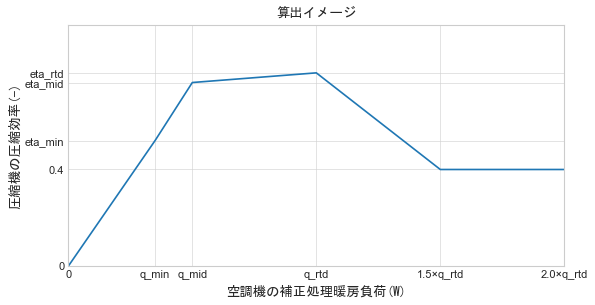

In [25]:
# 算出イメージ
plt.figure(figsize = (8, 4), dpi=80 )
plt.subplot2grid((1, 1), (0, 0))
plt.title('算出イメージ', fontdict={'fontproperties':fp})

q_rtd = 1
eta_rtd = 0.8
x_values =np.arange(0, 2.2, 0.05)
y_values =[eta_H(Q_dash_T_H*(3600 * 10**(-6)), eta_rtd*0.65, eta_rtd*0.95, eta_rtd, q_rtd*0.35, q_rtd*0.5, q_rtd) for Q_dash_T_H in x_values]
plt.plot(x_values, y_values)

        
ax=plt.gca()
ax.set_xlabel('空調機の補正処理暖房負荷(W)', fontdict={'fontproperties':fp})
ax.set_xticks([0, q_rtd*0.35, q_rtd*0.5, q_rtd, q_rtd*1.5, q_rtd*2.0], minor=False)
ax.set_xticklabels(['0', 'q_min', 'q_mid', 'q_rtd', '1.5×q_rtd', '2.0×q_rtd'], minor=False)
ax.set_xbound(lower=0, upper=2)

ax.set_ylabel('圧縮機の圧縮効率(-)', fontdict={'fontproperties':fp})
ax.set_yticks([0, eta_rtd*0.65, eta_rtd*0.95, eta_rtd, 0.4], minor=False)
ax.set_yticklabels(['0', 'eta_min', 'eta_mid', 'eta_rtd', '0.4'])
ax.set_ybound(lower=0, upper=1)

ax.grid(which='major', color='lightgray', alpha=0.7, linestyle='-')     

plt.show()

$Q_{hs,C,d,t} \div \left( 3600 \times 10^{-6} \right) \leq q_{hs,C,min}$の場合

$$ \eta_{C,d,t} = \eta_{C,min} - \left\{ q_{hs,C,min} - Q_{hs,C,d,t} \div \left( 3600 \times 10^{-6} \right) \right\} \times \frac{\eta_{C,min}}{q_{hs,C,min}} $$

$q_{hs,C,min} < Q_{hs,C,d,t} \div \left( 3600 \times 10^{-6} \right) \leq q_{hs,C,mid} $の場合

$$ \eta_{C,d,t} = \eta_{C,mid} - \left\{ q_{hs,C,mid} - Q_{hs,C,d,t} \div \left( 3600 \times 10^{-6} \right) \right\} \times \frac{\eta_{C,mid} - \eta_{C,min}}{q_{hs,C,mid} - q_{hs,C,min}} $$

$q_{hs,C,mid} < Q_{hs,C,d,t} \div \left( 3600 \times 10^{-6} \right) \leq q_{hs,C,rtd} $の場合

$$ \eta_{C,d,t} = \eta_{C,rtd} - \left\{ q_{hs,C,rtd} - Q_{hs,C,d,t} \div \left( 3600 \times 10^{-6} \right) \right\} \times \frac{\eta_{C,rtd} - \eta_{C,mid}}{q_{hs,C,rtd} - q_{hs,C,mid}} $$

$q_{hs,C,rtd} < Q_{hs,C,d,t} \div \left( 3600 \times 10^{-6} \right)$の場合

$$ \eta_{C,d,t} = max \left( 0.4, \: \eta_{C,rtd} - \left\{ Q_{hs,C,d,t} \div \left( 3600 \times 10^{-6} \right) - q_{hs,C,rtd} \right\} \times \frac{\eta_{C,rtd}}{q_{hs,C,rtd}} \right) $$

$Q_{hs,C,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの熱源機の冷房出力, MJ/h  
$\eta_{C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の圧縮機の圧縮機の圧縮効率  
$\eta_{C,mid}$：中間冷房能力運転時における圧縮機の圧縮効率  
$\eta_{C,min}$：最小冷房能力運転時における圧縮機の圧縮効率  
$\eta_{C,rtd}$：定格冷房能力運転時における圧縮機の圧縮効率   
$q_{hs,C,mid}$：空調機の中間冷房能力, W   
$q_{hs,C,min}$：空調機の最小冷房能力, W   
$q_{hs,C,rtd}$：空調機の定格冷房能力, W 

In [26]:
# これを冷房版に書き換える必要あり。関数は共通化しても良いかもしれない。
def eta_H(Q_dash_T_H, eta_H_min, eta_H_mid, eta_H_rtd, q_ac_H_min, q_ac_H_mid, q_ac_H_rtd):
    '''最小・中間・定格運転時における圧縮機の圧縮効率から当該時刻の値を外挿する'''
    # Q_dash_T_H：補正処理暖房負荷(MJ/h) 
    # eta_H_min：最小暖房能力運転時における圧縮機の圧縮効率(-)
    # eta_H_mid：中間暖房能力運転時における圧縮機の圧縮効率(-)
    # eta_H_rtd：定格暖房能力運転時における圧縮機の圧縮効率(-)
    # q_ac_H_min：空調機の最小暖房能力(W)
    # q_ac_H_mid：空調機の中間暖房能力(W)
    # q_ac_H_rtd：空調機の定格暖房能力(W)
    
    # 単位換算：MJ/h => W
    Q_dash_T_H_Wat = Q_dash_T_H / (3600 * 10**(-6))
    
    if Q_dash_T_H_Wat <= q_ac_H_min:
        return eta_H_min - (q_ac_H_min - Q_dash_T_H_Wat) * eta_H_min / q_ac_H_min
    elif q_ac_H_min < Q_dash_T_H_Wat and Q_dash_T_H_Wat <= q_ac_H_mid:
        return eta_H_mid - (q_ac_H_mid - Q_dash_T_H_Wat) * (eta_H_mid - eta_H_min) / (q_ac_H_mid - q_ac_H_min)
    elif q_ac_H_mid < Q_dash_T_H_Wat and Q_dash_T_H_Wat <= q_ac_H_rtd:
        return eta_H_rtd - (q_ac_H_rtd - Q_dash_T_H_Wat) * (eta_H_rtd - eta_H_mid) / (q_ac_H_rtd - q_ac_H_mid)
    elif q_ac_H_rtd < Q_dash_T_H_Wat:
        return max(0.4, eta_H_rtd - (Q_dash_T_H_Wat - q_ac_H_rtd) * eta_H_rtd / q_ac_H_rtd)
    
    else:
        raise Exeption

## 圧縮機の消費電力

### 暖房

$$ E_{E,comp,H,d,t} = \frac{{Q_{hs,H,d,t} \div \left(3600 \times 10^{-3} \right)}} {\eta_{H,d,t} \times e_{th,H,d,t} \times C_{df,d,t}} $$

$E_{E,comp,H,d,t}$：日付 $d$ の時刻 $t$ における暖房時の1時間当たりの圧縮機の消費電力量, kWh/h  
$Q_{hs,H,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの熱源機の暖房出力, MJ/h  
$C_{df,d,t}$：日付 $d$ の時刻 $t$ におけるデフロストに関する暖房出力補正係数  
$e_{th,H,d,t}$：日付 $d$ の時刻 $t$ における冷凍サイクルの理論暖房効率  
$\eta_{H,d,t}$：日付 $d$ の時刻 $t$ における暖房時の圧縮機の圧縮効率  

In [27]:
def get_e_e_comp_h(q_hs_h: np.ndarray, e_th_h: np.ndarray, eta_h: np.ndarray, c_df: np.ndarray) -> np.ndarray:
    """
    calculate the energy consumption of the compressor
    Args:
        q_hs_h: heating output of heat source, MJ/h (8760 times)  
        e_th_h: theoretical heating efficiency of refrigeration cycle (8760 times)
        eta_h: compression efficiency for heating (8760 times) 
        c_df: correction coefficiency for heating output when defrosting (8760 times)
    """
    
    return ( q_hs_h / (3600 * 10**(-3)) ) / (e_th_h * eta_h * c_df)

### 冷房

$$ E_{E,comp,C,d,t} = \frac{{Q_{hs,C,d,t} \div \left(3600 \times 10^{-3} \right)}} {\eta_{C,d,t} \times e_{th,C,d,t} } $$

$E_{E,comp,C,d,t}$：日付 $d$ の時刻 $t$ における暖房時の1時間当たりの圧縮機の消費電力量, kWh/h  
$Q_{hs,C,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの熱源機の冷房全熱出力, MJ/h  
$e_{th,C,d,t}$：日付 $d$ の時刻 $t$ における冷凍サイクルの理論暖房効率  
$\eta_{C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の圧縮機の圧縮効率  

In [28]:
def get_e_e_comp_c(q_hs_c: np.ndarray, e_th_c: np.ndarray, eta_c: np.ndarray) -> np.ndarray:
    """
    calculate the energy consumption of the compressor
    Args:
        q_hs_c: cooling output of heat source, MJ/h (8760 times)  
        e_th_c: theoretical cooling efficiency of refrigeration cycle (8760 times)
        eta_c: compression efficiency for cooling (8760 times) 
    """
    
    return ( q_hs_c / (3600 * 10**(-3)) ) / (e_th_c * eta_c)

## エネルギー消費量

$$ E_{E,H,d,t} = E_{E,comp,H,d,t} + E_{E,fan,H,d,t} $$

$E_{E,H,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの暖房の消費電力量, kWh/h  
$E_{E,fan,H,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの送風機の消費電力量のうちの暖房設備への付加分, kWh/h  
$E_{E,comp,H,d,t}$：日付 $d$ の時刻 $t$ における暖房時の1時間当たりの圧縮機の消費電力量, kWh/h  

In [29]:
def get_e_e_h(e_e_comp_h: np.ndarray, e_e_fan_h: np.ndarray) -> np.ndarray:
    """
    Args:
        e_e_comp_h: energy consumption of compressor for heating, kWh/h (8760 times)
        e_e_fan_h: energy consumption of fan for heating, kWh/h (8760 times)
    Returns:
        energy consumption for heating, kWh/h (8760 times)
    """
    
    return e_e_comp_h + e_e_fan_h

$$ E_{E,C,d,t} = E_{E,comp,C,d,t} + E_{E,fan,C,d,t}  $$

$E_{E,C,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの冷房の消費電力量, kWh/h  
$E_{E,fan,C,d,t}$：日付 $d$ の時刻 $t$ における1時間当たりの送風機の消費電力量のうちの冷房設備への付加分, kWh/h  
$E_{E,comp,C,d,t}$：日付 $d$ の時刻 $t$ における冷房時の1時間当たりの圧縮機の消費電力量, kWh/h

In [30]:
def get_e_e_c(e_e_comp_c: np.ndarray, e_e_fan_c: np.ndarray) -> np.ndarray:
    """
    Args:
        e_e_comp_c: Energy consumption of compressor, kWh/h (8760 times)
        e_e_fan_c: Energy consumption of fan, kWh/h (8760 times)
    Returns:
        energy consumption for cooling, kWh/h (8760 times)
    """
    
    return e_e_comp_c + e_e_fan_c